In [ ]:
import random
import optuna
import datetime

import polars as pl
import numpy as np

from typing import List, Any
import scipy.sparse as sp
from tqdm import tqdm

import implicit
import faiss
from gensim.models import Word2Vec

from catboost import Pool, CatBoost, CatBoostClassifier, CatBoostRanker, CatBoostRegressor
from sklearn.model_selection import train_test_split

In [ ]:
ad_features = pl.read_parquet('ad_features.parquet')
user_features = pl.read_parquet('user_features.parquet')
behavioral_logs = pl.read_parquet('behavior_logs.parquet')
data = pl.read_parquet('train.parquet')
test = pl.read_parquet('test.parquet')

## Описание данных

### ad_features

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| adgroup_id      | int                  | Идентификатор рекламы                    |
| cate_id         | int                  | Идентификатор категории                  |
| campaign_id     | int                  | Идентификатор рекламной компании         |
| customer        | int                  | Идентификатор рекламодателя              |
| brand           | int                  | Идентификатор бренда                     |
| price           | int                  | Цена товара                              |

One of the ad ID corresponds to an item, an item belongs to a category, an item belongs to a brand.


### user_features

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| userid          | int                  | Идентификатор пользователя               |
| cms_segid       | int                  | Идентификатор сегментированной группы пользователей|
| cms_group_id    | int                  | Идентификатор группы пользователей       |
| final_gender_code | int                | Пол пользователя (мужской – 1, женский – 2)|
| age_level       | int                  | Категория возраста пользователя          |
| pvalue_level    | int                  | Уровень потребления                      |
| shopping_level  | int                  | Уровень вовлеченности (значения из диапазона 1-3 от слабой до сильной) |
| occupation      | int                  | Род занятости (студент или нет)          |
| new_user_class_level | int             | Населенность города проживания           |

### behavioral_logs

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| user            | int                  | Идентификатор пользователя               |
| time_stamp      | int                  | Время                                    |
| btag            | str                  | Тип действия (**pv**: просмотр, **cart**: добавление в корзину, **fav**: добавление в избранное, **buy**: покупка) |
| cate            | int                  | Идентификатор категории                  |
| brand           | str                  | Идентификатор бренда                     |


### data

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| user            | int                  | Идентификатор пользователя               |
| time_stamp      | int                  | Время                                    |
| adgroup_id      | int                  | Идентификатор рекламы                    |
| clk             | int                  | Был ли клик?                             |

## Оценивание

В качестве метрики качества используется ndcg@10. Чтобы получить максимальный балл, достаточно добиться ndcg@10 = ?

В качестве `y_relevant` используется те рекламные объявления, по которым были клики после собранной истории взаимодействий

In [ ]:
TOP_K = 10
N_CANDIDATES = 50


def user_intersection(y_rel: List[Any], y_rec: List[Any], k: int = TOP_K) -> int:
    """
    :param y_rel: relevant items
    :param y_rec: recommended items
    :param k: number of top recommended items
    :return: number of items in intersection of y_rel and y_rec (truncated to top-K)
    """
    return len(set(y_rec[:k]).intersection(set(y_rel)))

def user_recall(y_rel: List[Any], y_rec: List[Any], k: int = TOP_K) -> float:
    """
    :param y_rel: relevant items
    :param y_rec: recommended items
    :param k: number of top recommended items
    :return: percentage of found relevant items through recommendations
    """
    return user_intersection(y_rel, y_rec, k) / len(set(y_rel))


def user_ndcg(y_rel: List[Any], y_rec: List[Any], k: int = TOP_K) -> float:
    """
    :param y_rel: relevant items
    :param y_rec: recommended items
    :param k: number of top recommended items
    :return: ndcg metric for user recommendations
    """
    dcg = sum([1. / np.log2(idx + 2) for idx, item in enumerate(y_rec[:k]) if item in y_rel])
    idcg = sum([1. / np.log2(idx + 2) for idx, _ in enumerate(zip(y_rel, np.arange(k)))])
    return dcg / idcg

In [ ]:
RANDOM_STATE = 42

def set_seed():
    random.seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)


def get_recommendations(user_embs: np.array, item_embs: np.array, k: int = TOP_K):
    # строим индекс объектов
    index = faiss.IndexFlatIP(item_embs.shape[1])
    index.add(item_embs)

    # строим рекомендации с помощью dot-product расстояния
    # с запасом, чтобы после фильтрации просмотренных осталось хотя бы TOP_K
    return index.search(user_embs, k)

In [ ]:
data_positives = data.filter(pl.col('clk') == 1)
data_negatives = (
    data
    .filter(pl.col('clk') == 0)
    .join(data_positives, on=['user', 'adgroup_id'], how='anti')
)

data = pl.concat([data_positives, data_negatives]).sort('time_stamp')
data

user,time_stamp,adgroup_id,clk
i64,i64,i64,i64
227368,1494000000,680144,1
874257,1494000000,27032,0
874257,1494000000,54756,0
874257,1494000000,194654,0
874257,1494000000,382468,0
874257,1494000000,383937,0
626053,1494000000,513129,0
227368,1494000000,572396,0
227368,1494000000,576624,0


In [ ]:
timestamp_threshold = data['time_stamp'].quantile(0.9)
train_df = data.filter(pl.col('time_stamp') <= timestamp_threshold)
test_df = data.filter(pl.col('time_stamp') > timestamp_threshold)

## W2V

Задачей w2v будет предсказание следующего рекламного объявления, после которого будет клик

In [ ]:
grouped_df = (
    train_df
    # оставляем только положительные взаимодействия
    .filter(pl.col('clk') == 1)
    .rename({'user': 'user_id'})
    .groupby('user_id')
    .agg([
        # для валидации оставим последнее взаимодействие в истории
        pl.col('adgroup_id').apply(lambda x: x[:-1]).alias('train_item_ids'),
        pl.col('adgroup_id').apply(lambda x: x[-1:]).alias('test_item_ids'),
    ])
    # и оставим только те сессии, где есть какая-то тренировочная выборка
    .filter(pl.col('train_item_ids').list.lengths() > 0)
)
grouped_df

user_id,train_item_ids,test_item_ids
i64,list[i64],list[i64]
667824,"[723756, 637176, 608803]",[691580]
262264,[781998],[691580]
61056,"[326056, 637729, … 480818]",[656901]
244736,[125651],[268507]
1136448,"[623140, 675562]",[786075]
229328,[572011],[632699]
300240,"[69424, 438526, … 18630]",[602122]
1056208,[416816],[280747]
1113016,[589152],[188097]


In [ ]:
def evaluate_model(model):
    ndcg_list = []
    recall_list = []
    # для оптимизации вычислений будем оценивать модель только на подвыборке
    for train_ids, y_rel in grouped_df.head(10_000).select('train_item_ids', 'test_item_ids').rows():
        model_preds = model.predict_output_word(
            train_ids[-model.window:],
            topn=(TOP_K + len(train_ids))
        )

        if model_preds is None:
            ndcg_list.append(0)
            recall_list.append(0)
            continue

        y_rec = [pred[0] for pred in model_preds]
        ndcg_list.append(user_ndcg(y_rel, y_rec, TOP_K))
        recall_list.append(user_recall(y_rel, y_rec, TOP_K))
    return np.mean(ndcg_list), np.mean(recall_list)

def objective(trial):
    sg = trial.suggest_categorical('sg', [0, 1])
    window = trial.suggest_int('window', 1, 10)
    ns_exponent = trial.suggest_float('ns_exponent', -3, 3)
    negative = trial.suggest_int('negative', 3, 20)
    min_count = trial.suggest_int('min_count', 0, 20)
    vector_size = trial.suggest_categorical('vector_size', [16, 32, 64, 128])

    print({
        'sg': sg,
        'window_len': window,
        'ns_exponent': ns_exponent,
        'negative': negative,
        'min_count': min_count,
        'vector_size': vector_size,
    })

    set_seed()
    model = Word2Vec(
        grouped_df['train_item_ids'].to_list(),
        window=window,
        sg=sg,
        hs=0,
        min_count=min_count,
        vector_size=vector_size,
        negative=negative,
        ns_exponent=ns_exponent,
        seed=RANDOM_STATE,
        epochs=10,
    )

    mean_ndcg, mean_recall = evaluate_model(model)
    print(f'NDCG@{TOP_K} = {mean_ndcg}, Recall@{TOP_K} = {mean_recall}')
    return mean_recall


study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=100)

study.best_params

In [ ]:
set_seed()
params = {
    'hs': 0,
    'seed': RANDOM_STATE,
    'epochs': 30,
    'sg': 1,
    'window': 9,
    'ns_exponent': -0.15,
    'negative': 10,
    'min_count': 10,
    'vector_size': 64,
}
w2v_model = Word2Vec(
    grouped_df['train_item_ids'].to_list(),
    **params
)

mean_ndcg, mean_recall = evaluate_model(w2v_model)
print(f'NDCG@{TOP_K} = {mean_ndcg}, Recall@{TOP_K} = {mean_recall}')

NDCG@10 = 0.029254051629789397, Recall@10 = 0.0524


Построим финальные рекомендации

In [ ]:
# датафрейм состоит из id пользователей, для которых строим рекомендации и их истории
eval_grouped_df = (
    test
    .join(
        data.filter(pl.col('clk') == 1).groupby('user').agg(pl.col('adgroup_id').alias('user_history')),
        left_on='user_id', right_on='user', how='left'
    )
)

set_seed()
w2v_model = Word2Vec(
    eval_grouped_df['user_history'].drop_nulls().to_list(),
    **params
)

In [ ]:
submission = []
for user_id, user_history in tqdm(eval_grouped_df.rows()):
    y_rec = []

    if user_history is not None:
        model_preds = w2v_model.predict_output_word(
            user_history[-w2v_model.window:],
            topn=(N_CANDIDATES + len(user_history))
        )
        if model_preds is not None:
            y_rec = [pred[0] for pred in model_preds][:N_CANDIDATES]

    submission.append([user_id, y_rec])

submission = pl.DataFrame(submission, schema=('user_id', 'y_rec'))
submission.write_parquet('w2v_candidates.parquet')
submission

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284622/284622 [02:41<00:00, 1765.26it/s]


user_id,y_rec
i64,list[i64]
931592,[]
599304,"[198552, 660683, … 691283]"
143960,"[690381, 709851, … 581804]"
359256,[]
733880,"[662393, 661771, … 489942]"
155384,[]
199736,[]
811416,"[438195, 747157, … 644995]"
668744,"[737483, 713321, … 782118]"


Уже такое решение выбивает `Recall@10 = 0.026` и `NDCG@10 = 0.032`, но такой подход не использует все возможные данные и страдает от проблемы холодного старта

## ALS

In [ ]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, item_id, label in (
    train_df
    .filter(pl.col('clk') == 1)
    .select('user', 'adgroup_id', 'clk')
    .rows()
):
    rows.append(user_id)
    cols.append(item_id)
    values.append(label)

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_data

<1141730x846798 sparse matrix of type '<class 'numpy.float32'>'
	with 1086511 stored elements in Compressed Sparse Row format>

In [ ]:
train_grouped_df = (
    train_df
    .groupby('user')
    .agg([
        pl.col('adgroup_id').alias('user_history'),
        pl.col('clk').alias('user_history_target'),
    ])
)

test_grouped_df = (
    test_df
    .filter(pl.col('clk') == 1)
    .groupby('user')
    .agg(pl.col('adgroup_id').alias('y_rel'))
    .join(train_grouped_df, 'user', how='left')
)
test_grouped_df

user,y_rel,user_history,user_history_target
i64,list[i64],list[i64],list[i64]
1124664,[382740],"[11811, 338854, … 503784]","[1, 0, … 0]"
604912,"[612667, 712002]","[140132, 622536, … 659614]","[0, 0, … 0]"
872512,[333313],"[12684, 775226, … 611507]","[0, 0, … 0]"
883984,[743577],null,null
716464,[840673],null,null
1079360,[502832],"[96563, 728414, … 603732]","[0, 0, … 0]"
464128,"[688144, 441194]","[321973, 434838, … 295533]","[0, 0, … 0]"
798048,[387221],"[323964, 104401, … 499651]","[1, 0, … 0]"
661864,"[802471, 144265, 671166]","[621229, 652514, … 639026]","[0, 0, … 0]"


In [ ]:
def objective(trial):
    factors = trial.suggest_int('factors', 8, 64)
    iterations = trial.suggest_int('iterations', 5, 20)
    alpha = trial.suggest_float('alpha', 0.1, 100.0)
    regularization = trial.suggest_float('regularization', 1e-3, 1.0)

    print({
        'factors': factors,
        'iterations': iterations,
        'alpha': alpha,
        'regularization': regularization,
    })

    set_seed()
    als_model = implicit.als.AlternatingLeastSquares(
        factors=factors,
        iterations=iterations,
        random_state=RANDOM_STATE,
        alpha=alpha,
        regularization=regularization
    )
    als_model.fit(user_item_data)

    user_embs = als_model.user_factors
    item_embs = als_model.item_factors

    index = faiss.IndexFlatIP(item_embs.shape[1])
    index.add(item_embs)

    _, recs = index.search(user_embs[test_grouped_df['user'].to_list()], TOP_K)

    ndcg_list = []
    recall_list = []
    for y_rec, (_, y_rel) in zip(recs, test_grouped_df.rows()):
        ndcg_list.append(user_ndcg(y_rel, y_rec))
        recall_list.append(user_recall(y_rel, y_rec))

    mean_ndcg = np.mean(ndcg_list)
    mean_recall = np.mean(recall_list)
    print(f'NDCG@{TOP_K} = {mean_ndcg:.4f}, Recall@{TOP_K} = {mean_recall:.4f}')
    return mean_recall


study = optuna.create_study(directions=('maximize',))
study.optimize(objective, n_trials=20)

study.best_params

In [ ]:
set_seed()
params = {
    'factors': 48,
    'iterations': 15,
    'random_state': RANDOM_STATE,
    'regularization': 1e-2,
    'alpha': 100,
}
als_model = implicit.als.AlternatingLeastSquares(**params)
als_model.fit(user_item_data)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
user_embs = als_model.user_factors
item_embs = als_model.item_factors

index = faiss.IndexFlatIP(item_embs.shape[1])
index.add(item_embs)

_, recs = index.search(user_embs[test_grouped_df['user'].to_list()], TOP_K)

ndcg_list = []
recall_list = []
for y_rec, (_, y_rel, _, _) in zip(recs, test_grouped_df.rows()):
    ndcg_list.append(user_ndcg(y_rel, y_rec))
    recall_list.append(user_recall(y_rel, y_rec))

mean_ndcg = np.mean(ndcg_list)
mean_recall = np.mean(recall_list)
print(f'NDCG@{TOP_K} = {mean_ndcg:.4f}, Recall@{TOP_K} = {mean_recall:.4f}')

NDCG@10 = 0.0200, Recall@10 = 0.0315


Для того, чтобы использовать знания о не-кликах (поле clk = 0), можно было бы для пользователей без истории кликов использовать их в качестве эмбеддингов пользователя (только со знаком минус, так как решаем обратную задачу). Но в этом датасете это не дает большой прирост, в то время как без знака минус этот подход сильно улучшает метрики.

Это может показать странным, почему поиск ближайших соседей на основе не-кликнутых объявлений работает, но с другой стороны данный датасет был собран из рекомендаций предыдущей модели, то есть любая строчка в датасете является предсказанием другой модели, у которой, вероятнее всего было еще больше данных о пользователе и рекламном объявлении, то есть таким образом мы смогли дистиллировать более сложную модель, о которой ничего не знали. Однако, этот подход может не работать на реальных пользователях, так как офлайн метрики не учитывают все возможные варианты и мы могли просто переобучиться, что часто случается в рекомендательных системах ;(

In [ ]:
user_embs = als_model.user_factors.copy()
item_embs = als_model.item_factors.copy()

user_embs = user_embs[test_grouped_df['user'].to_list()]

for ind, (_, _, user_history, user_history_target) in enumerate(test_grouped_df.rows()):
    if user_history_target is not None and sum(user_history_target) == 0:
        user_embs[ind] = np.mean(item_embs[user_history], axis=0)

index = faiss.IndexFlatIP(item_embs.shape[1])
index.add(item_embs)

_, recs = index.search(user_embs, TOP_K)

ndcg_list = []
recall_list = []
for y_rec, (_, y_rel, _, _) in zip(recs, test_grouped_df.rows()):
    ndcg_list.append(user_ndcg(y_rel, y_rec))
    recall_list.append(user_recall(y_rel, y_rec))

mean_ndcg = np.mean(ndcg_list)
mean_recall = np.mean(recall_list)
print(f'NDCG@{TOP_K} = {mean_ndcg:.4f}, Recall@{TOP_K} = {mean_recall:.4f}')

NDCG@10 = 0.0229, Recall@10 = 0.0370


построим финальные рекомендации

In [ ]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, item_id, label in data.filter(pl.col('clk') == 1).select('user', 'adgroup_id', 'clk').rows():
    rows.append(user_id)
    cols.append(item_id)
    values.append(label)

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_data

<1141730x846798 sparse matrix of type '<class 'numpy.float32'>'
	with 1202728 stored elements in Compressed Sparse Row format>

In [ ]:
set_seed()
als_model = implicit.als.AlternatingLeastSquares(
    factors=48,
    iterations=15,
    random_state=RANDOM_STATE,
    regularization=1e-2,
    alpha=100,
)
als_model.fit(user_item_data)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
grouped_df = (
    test
    .join(
        data
        .groupby('user')
        .agg([
            pl.col('adgroup_id').alias('user_history'),
            pl.col('clk').alias('user_history_target'),
        ]),
        left_on='user_id', right_on='user', how='left'
    )
)

grouped_df

user_id,user_history,user_history_target
i64,list[i64],list[i64]
931592,"[622589, 120101, … 764466]","[0, 0, … 0]"
599304,"[491943, 477588, … 748738]","[0, 0, … 0]"
143960,"[607548, 576278, … 827413]","[1, 1, … 0]"
359256,"[671112, 600840, 707799]","[0, 0, 0]"
733880,"[424212, 813034, … 708111]","[1, 1, … 0]"
155384,"[354706, 287387, … 582427]","[0, 0, … 0]"
199736,"[217294, 266886, … 762865]","[0, 0, … 0]"
811416,"[701555, 328703, … 615631]","[0, 0, … 0]"
668744,"[18344, 6401, … 645237]","[0, 0, … 0]"


In [ ]:
user_embs = als_model.user_factors.copy()
item_embs = als_model.item_factors.copy()

user_embs = user_embs[grouped_df['user_id'].to_list()]

for ind, (_, user_history, user_history_target) in enumerate(grouped_df.rows()):
    if user_history_target is not None and sum(user_history_target) == 0:
        user_history = [item_id for item_id in user_history if item_id < item_embs.shape[0]]
        user_embs[ind] = np.mean(item_embs[user_history], axis=0)

index = faiss.IndexFlatIP(item_embs.shape[1])
index.add(item_embs)

_, recs = index.search(user_embs, N_CANDIDATES)

submission = []
for y_rec, (user_id, user_history, _) in tqdm(zip(recs, grouped_df.rows()), total=len(grouped_df)):
    submission.append([user_id, list(y_rec)])

submission = pl.DataFrame(submission, schema=('user_id', 'y_rec'))
submission.write_parquet('als_candidates.parquet')
submission

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284622/284622 [00:01<00:00, 247085.51it/s]


user_id,y_rec
i64,list[i64]
931592,"[763065, 748779, … 722867]"
599304,"[746762, 655187, … 823006]"
143960,"[690381, 709851, … 713548]"
359256,"[671112, 638026, … 554931]"
733880,"[691936, 632432, … 544302]"
155384,"[698147, 710164, … 679650]"
199736,"[633388, 698147, … 678510]"
811416,"[618707, 681299, … 644035]"
668744,"[681970, 599255, … 629088]"


Такое решение уже набирает необходимый порог с метрикой `NDCG@10 = 0.042` (без хака `NDCG@10 = 0.032`)

## Ранжирующая модель

Для того, чтобы корректно использоавть `behavioral_logs` без дата-ликов, можно разбить все время в датасете на бины, например по дням. Тогда, для каждого дня из тренировочной выборки мы будем строить различные признаки по `behavioral_logs` за все предыдущие дни.

In [ ]:
start_date = datetime.datetime.fromtimestamp(data['time_stamp'][0])
end_date = datetime.datetime.fromtimestamp(data['time_stamp'][-1])

dates_delta = datetime.timedelta(days=1)

In [ ]:
def build_grouped_df(behavioral_logs, cols):
    """
    Данная функция строит признаки из behavioral_logs данных, а именно по набору колонок считает популярность выбранной комбинации.

    Например, для cols = ['cate_id'] мы получим для категории значение в процентах, сколько событий было относительно других категорий
    Для cols = ['user_id', 'cate_id'] мы получим в процентах число событий в данной категории для данного пользователя относительно других пользователей
    """
    col = '_'.join(cols)

    grouped_df = (
        behavioral_logs
        .groupby(cols)
        .agg([
            pl.col('btag_buy').sum().alias('buy_count'),
            pl.col('btag_fav').sum().alias('fav_count'),
            pl.col('btag_pv').sum().alias('pv_count'),
            pl.col('btag_cart').sum().alias('cart_count'),
        ])
    )

    if len(cols) == 1:
        return (
            grouped_df
            .with_columns([
                (pl.col('buy_count') / pl.col('buy_count').sum()).alias(f'{col}_buy_ctr'),
                (pl.col('fav_count') / pl.col('fav_count').sum()).alias(f'{col}_fav_ctr'),
                (pl.col('pv_count') / pl.col('pv_count').sum()).alias(f'{col}_pv_ctr'),
                (pl.col('cart_count') / pl.col('cart_count').sum()).alias(f'{col}_cart_ctr'),
            ])
            .select([*cols, f'{col}_buy_ctr', f'{col}_fav_ctr', f'{col}_pv_ctr', f'{col}_cart_ctr'])
        )
    else:
        return (
            grouped_df
            .with_columns([
                (pl.col('buy_count') / pl.col('buy_count').sum().over(cols[0])).alias(f'{col}_buy_ctr'),
                (pl.col('fav_count') / pl.col('fav_count').sum().over(cols[0])).alias(f'{col}_fav_ctr'),
                (pl.col('pv_count') / pl.col('pv_count').sum().over(cols[0])).alias(f'{col}_pv_ctr'),
                (pl.col('cart_count') / pl.col('cart_count').sum().over(cols[0])).alias(f'{col}_cart_ctr'),
            ])
            .select([*cols, f'{col}_buy_ctr', f'{col}_fav_ctr', f'{col}_pv_ctr', f'{col}_cart_ctr'])
        )

In [ ]:
behavioral_logs_cate_by_period = []
behavioral_logs_brand_by_period = []

behavioral_logs_user_segid_by_period = []
behavioral_logs_user_groupid_by_period = []

behavioral_logs_user_cate_by_period = []
behavioral_logs_user_brand_by_period = []

for i in range(int((end_date - start_date) / dates_delta + 1)):
    # рассматриваем только те события, произошедшие до верхней границе диапазона времени
    dates = [start_date, start_date + (i + 1) * dates_delta]
    print(dates)

    # работаем только с промежутком dates_delta
    behavioral_logs_sample = (
        behavioral_logs
        .filter(pl.col('time_stamp') >= datetime.datetime.timestamp(dates[0]))
        .filter(pl.col('time_stamp') < datetime.datetime.timestamp(dates[1]))
        .to_dummies('btag')
        .rename({'user': 'user_id', 'cate': 'cate_id'})
        .join(user_features, left_on='user_id', right_on='userid')
    )

    behavioral_logs_cate_by_period.append(build_grouped_df(behavioral_logs_sample, ['cate_id']))
    behavioral_logs_brand_by_period.append(build_grouped_df(behavioral_logs_sample, ['brand']))
    behavioral_logs_user_segid_by_period.append(build_grouped_df(behavioral_logs_sample, ['cms_segid']))
    behavioral_logs_user_groupid_by_period.append(build_grouped_df(behavioral_logs_sample, ['cms_group_id']))
    behavioral_logs_user_cate_by_period.append(build_grouped_df(behavioral_logs_sample, ['user_id', 'cate_id']))
    behavioral_logs_user_brand_by_period.append(build_grouped_df(behavioral_logs_sample, ['user_id', 'brand']))

[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 6, 19, 0)]
[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 7, 19, 0)]
[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 8, 19, 0)]
[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 9, 19, 0)]
[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 10, 19, 0)]
[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 11, 19, 0)]
[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 12, 19, 0)]
[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 13, 19, 0)]


In [ ]:
train_df_by_period = []
for i in range(int((end_date - start_date) / dates_delta + 1)):
    dates = [start_date + i * dates_delta, start_date + (i + 1) * dates_delta]
    print(dates)

    if i == 0:
        # для первого диапазона у нас нет истории и везде будут использоваться значения null
        # тем не менее, дальше мы будем конкатенировать данные куски и нужно сохранить схему таблиц (используемые колонки)
        behavioral_logs_user_cate_grouped_df = pl.DataFrame({}, schema=behavioral_logs_user_cate_by_period[0].schema)
        behavioral_logs_user_brand_grouped_df = pl.DataFrame({}, schema=behavioral_logs_user_brand_by_period[0].schema)
        behavioral_logs_cate_grouped_df = pl.DataFrame({}, schema=behavioral_logs_cate_by_period[0].schema)
        behavioral_logs_brand_grouped_df = pl.DataFrame({}, schema=behavioral_logs_brand_by_period[0].schema)
        behavioral_logs_user_segid_grouped_df = pl.DataFrame({}, schema=behavioral_logs_user_segid_by_period[0].schema)
        behavioral_logs_user_groupid_by_period = pl.DataFrame({}, schema=behavioral_logs_user_groupid_by_period[0].schema)
    else:
        behavioral_logs_user_cate_grouped_df = behavioral_logs_user_cate_by_period[i - 1]
        behavioral_logs_user_brand_grouped_df = behavioral_logs_user_brand_by_period[i - 1]
        behavioral_logs_cate_grouped_df = behavioral_logs_cate_by_period[i - 1]
        behavioral_logs_brand_grouped_df = behavioral_logs_brand_by_period[i - 1]
        behavioral_logs_user_segid_grouped_df = behavioral_logs_user_segid_by_period[i - 1]
        behavioral_logs_user_groupid_by_period = behavioral_logs_user_groupid_by_period[i - 1]

    train_df_by_period.append(
        data
        .filter(pl.col('time_stamp') >= datetime.datetime.timestamp(dates[0]))
        .filter(pl.col('time_stamp') < datetime.datetime.timestamp(dates[1]))
        .rename({'user': 'user_id', 'clk': 'target'})
        .join(ad_features, on='adgroup_id')
        .join(user_features, left_on='user_id', right_on='userid')
        .join(behavioral_logs_user_cate_grouped_df, on=('user_id', 'cate_id'), how='left')
        .join(behavioral_logs_user_brand_grouped_df, on=('user_id', 'brand'), how='left')
        .join(behavioral_logs_cate_grouped_df, on='cate_id', how='left')
        .join(behavioral_logs_brand_grouped_df, on='brand', how='left')
        .join(behavioral_logs_user_segid_grouped_df, on='cms_segid', how='left')
        .join(behavioral_logs_user_groupid_by_period, on='cms_group_id', how='left')
    )

[datetime.datetime(2017, 5, 5, 19, 0), datetime.datetime(2017, 5, 6, 19, 0)]
[datetime.datetime(2017, 5, 6, 19, 0), datetime.datetime(2017, 5, 7, 19, 0)]
[datetime.datetime(2017, 5, 7, 19, 0), datetime.datetime(2017, 5, 8, 19, 0)]
[datetime.datetime(2017, 5, 8, 19, 0), datetime.datetime(2017, 5, 9, 19, 0)]
[datetime.datetime(2017, 5, 9, 19, 0), datetime.datetime(2017, 5, 10, 19, 0)]
[datetime.datetime(2017, 5, 10, 19, 0), datetime.datetime(2017, 5, 11, 19, 0)]
[datetime.datetime(2017, 5, 11, 19, 0), datetime.datetime(2017, 5, 12, 19, 0)]
[datetime.datetime(2017, 5, 12, 19, 0), datetime.datetime(2017, 5, 13, 19, 0)]


In [ ]:
ranking_dataset = pl.concat(train_df_by_period)

# уберем пользователей без кликов, так как это тривиальные группы и скорее навредят обучению
filtered_users = ranking_dataset.filter(pl.col('target') == 1).groupby('user_id').count().select('user_id')
ranking_dataset = ranking_dataset.join(filtered_users, on='user_id')

In [ ]:
rolling_ctr_features = [
    (['user_id', 'cate_id'], 'user_cate_ctr'),
    (['user_id', 'brand'], 'user_brand_ctr'),
    (['adgroup_id'], 'adgroup_id_ctr'),
    (['user_id'], 'user_id_ctr'),
    (['adgroup_id', 'cms_group_id'], 'adgroup_id_group_id_ctr'),
    (['adgroup_id', 'cms_segid'], 'adgroup_id_segid_ctr'),
    (['adgroup_id', 'final_gender_code'], 'adgroup_id_gender_ctr'),
    (['adgroup_id', 'age_level'], 'adgroup_id_age_ctr'),
]

# посчитаем скользящее среднее для разных пар категориальных признаков
for input_cols, new_col_name in rolling_ctr_features:
    ranking_dataset = (
        ranking_dataset
        .with_columns([
            # скользящая сумма количества кликов
            pl.col('target').cumcount().over(*input_cols).alias('rolling_count'),
            # скользящее число показов рекомендаций
            (pl.col('target').cumsum().over(*input_cols) - pl.col('target')).alias('rolling_sum')
        ])
        .with_columns([
            # итого получаем скользящий ctr по времени, который не содержит дата-ликов
            (pl.col('rolling_sum') / pl.col('rolling_count')).alias(new_col_name)
        ])
        .drop(['rolling_count', 'rolling_sum'])
    )

ranking_dataset

user_id,time_stamp,adgroup_id,target,cate_id,campaign_id,customer,brand,price,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,user_id_cate_id_buy_ctr,user_id_cate_id_fav_ctr,user_id_cate_id_pv_ctr,user_id_cate_id_cart_ctr,user_id_brand_buy_ctr,user_id_brand_fav_ctr,user_id_brand_pv_ctr,user_id_brand_cart_ctr,cate_id_buy_ctr,cate_id_fav_ctr,cate_id_pv_ctr,cate_id_cart_ctr,brand_buy_ctr,brand_fav_ctr,brand_pv_ctr,brand_cart_ctr,cms_segid_buy_ctr,cms_segid_fav_ctr,cms_segid_pv_ctr,cms_segid_cart_ctr,cms_group_id_buy_ctr,cms_group_id_fav_ctr,cms_group_id_pv_ctr,cms_group_id_cart_ctr,user_cate_ctr,user_brand_ctr,adgroup_id_ctr,user_id_ctr,adgroup_id_group_id_ctr,adgroup_id_segid_ctr,adgroup_id_gender_ctr,adgroup_id_age_ctr
i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
227368,1494000000,680144,1,6261,112846,5406,420137,596.0,0,4,2,4,null,3,0,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874257,1494000000,27032,0,5851,133243,13072,11022,8.8,0,3,2,3,null,3,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
874257,1494000000,54756,0,4609,17377,68631,304332,46.0,0,3,2,3,null,3,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
874257,1494000000,194654,0,5487,57459,43184,139647,8.0,0,3,2,3,null,3,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
874257,1494000000,382468,0,6426,292338,239574,null,18.0,0,3,2,3,null,3,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
874257,1494000000,383937,0,5443,398575,51721,156936,5.2,0,3,2,3,null,3,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
626053,1494000000,513129,0,6251,264355,214436,58727,168.0,0,2,2,2,null,3,0,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227368,1494000000,572396,0,4281,107755,96798,194203,362.0,0,4,2,4,null,3,0,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
227368,1494000000,576624,0,1665,202498,103078,null,425.0,0,4,2,4,null,3,0,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN


In [ ]:
# после проделанных преобразований категориальные признаки не нужны и скорее замедляют процесс обучения
cat_features = []
drop_columns = [
    'time_stamp',
    'user_id',
    'adgroup_id',
    'cate_id',
    'customer',
    'brand',
    'cms_segid',
    'cms_group_id'
]

In [ ]:
# в качестве валидации выберем последние 10% данных по времени
test_size = int(len(ranking_dataset) * 0.1)
train_dataset, test_dataset = ranking_dataset.head(-test_size), ranking_dataset.tail(test_size)

# нужно отсортировать по тому полю, которое будет использоваться в качестве group_id в Pool
train_dataset = train_dataset.sort('user_id')
test_dataset = test_dataset.sort('user_id')

train_pool = Pool(
    train_dataset.drop(['target'] + drop_columns).to_pandas(),
    train_dataset['target'].to_list(),
    group_id=train_dataset['user_id'].to_list(),
    cat_features=cat_features
)

test_pool = Pool(
    test_dataset.drop(['target'] + drop_columns).to_pandas(),
    test_dataset['target'].to_list(),
    group_id=test_dataset['user_id'].to_list(),
    cat_features=cat_features
)

ranking_model = CatBoostClassifier(**{
    'iterations': 100,
    'verbose': False,
    'random_state': RANDOM_STATE,
    'use_best_model': True,
    'custom_metric': [f'NDCG:top={TOP_K};denominator=LogPosition', f'MAP:top={TOP_K}', 'AUC:type=Ranking', 'QueryAUC:type=Ranking'],
})
ranking_model.fit(train_pool, plot=True, eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

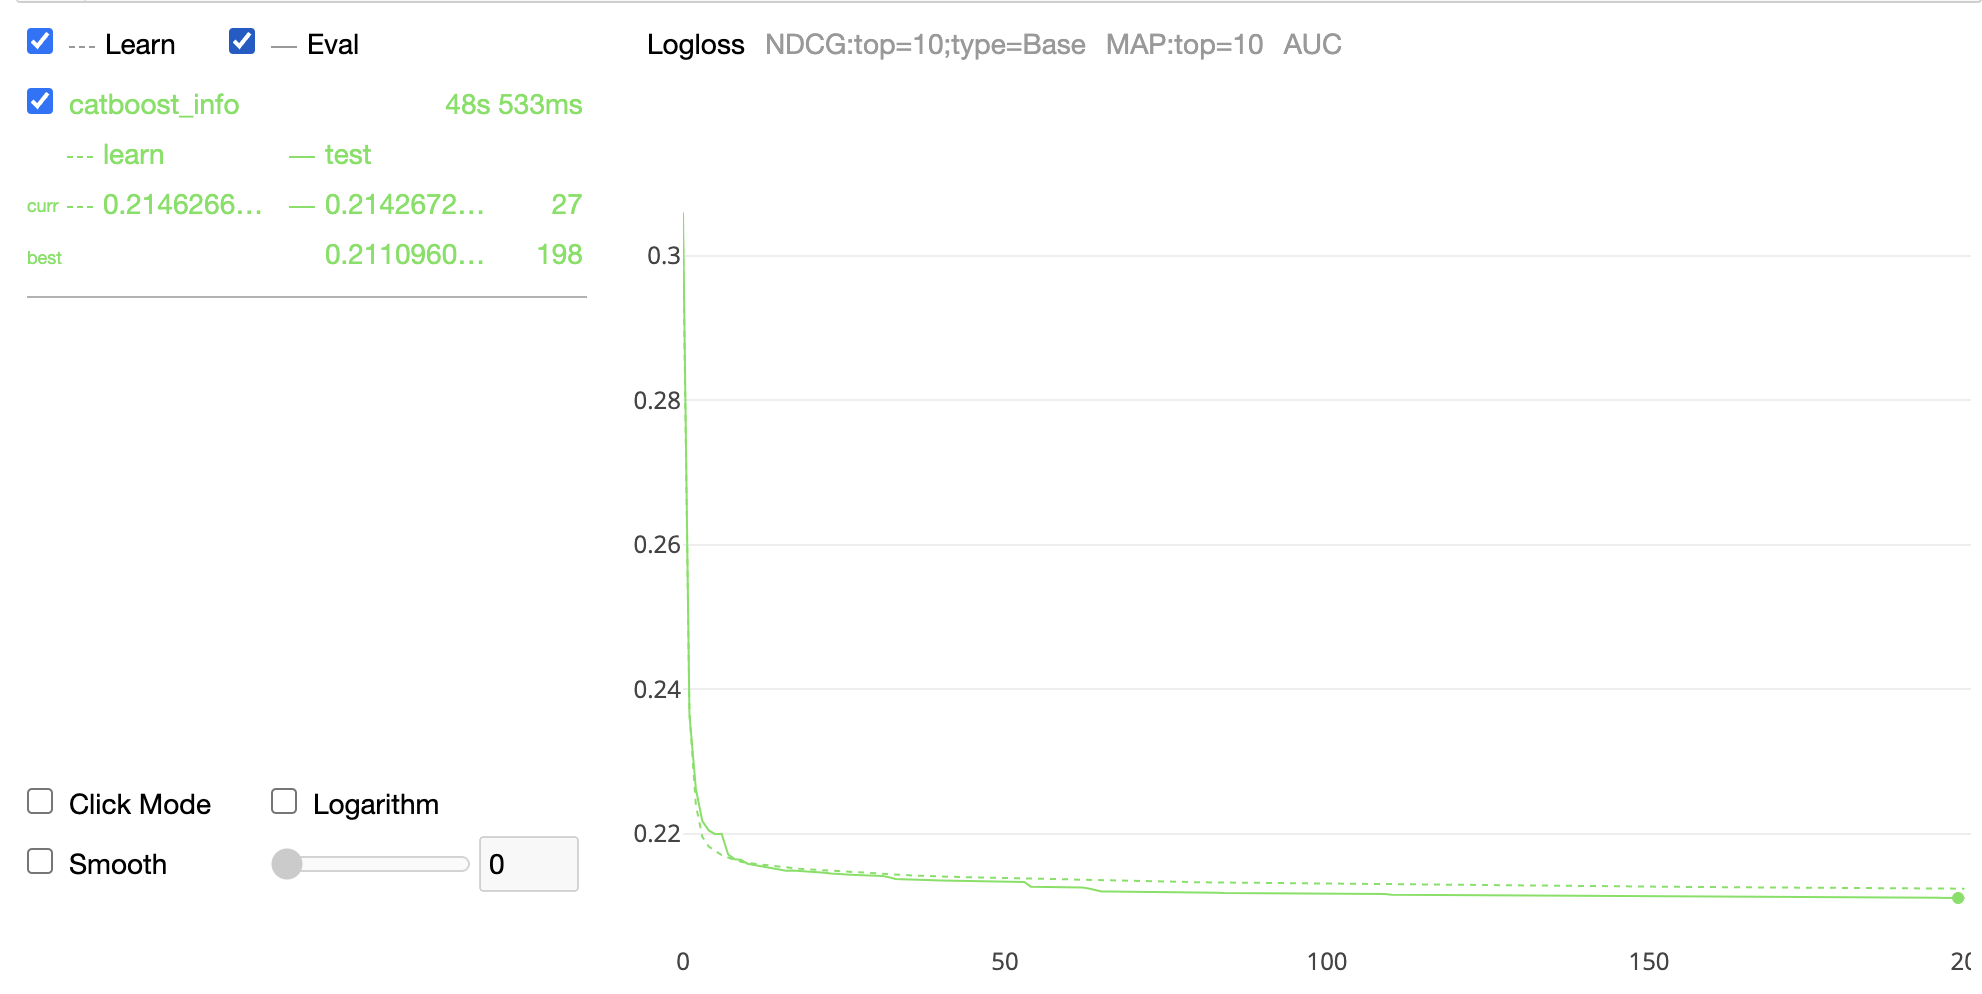

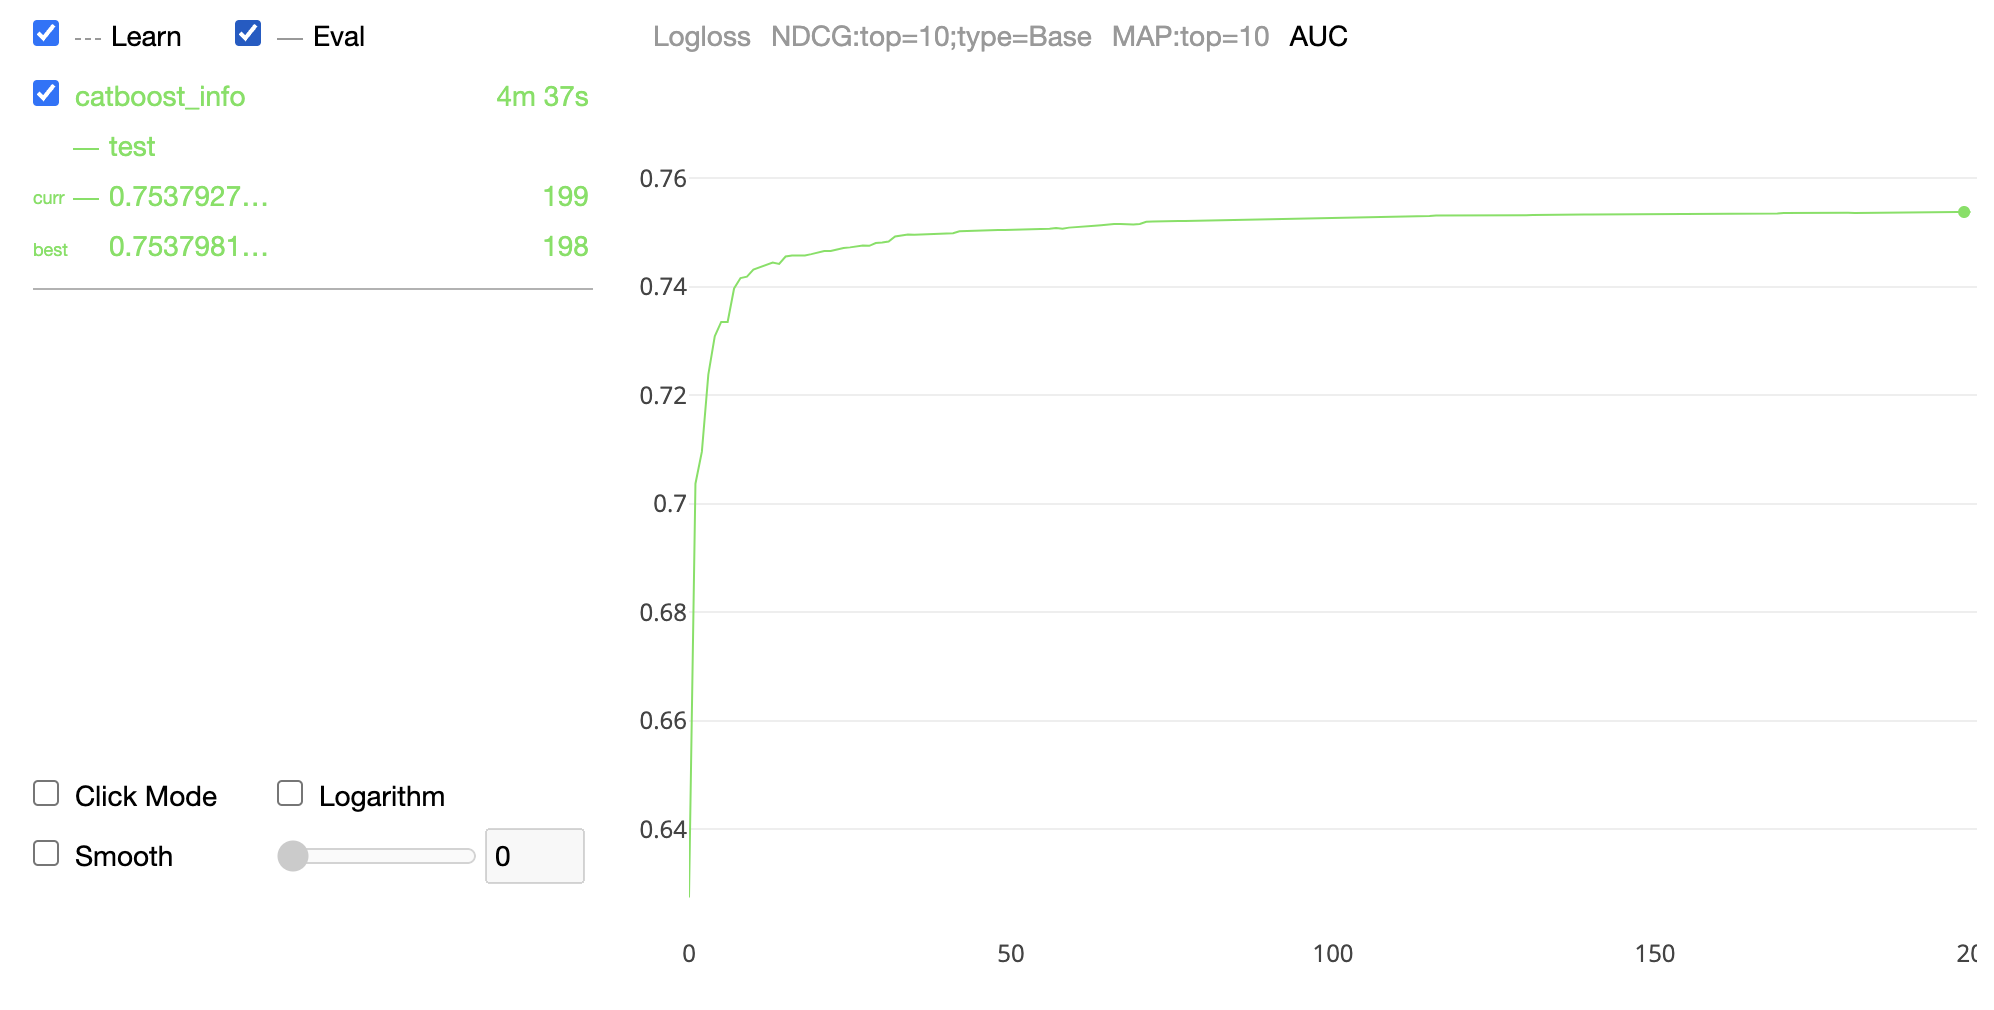

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
All-NaN slice encountered


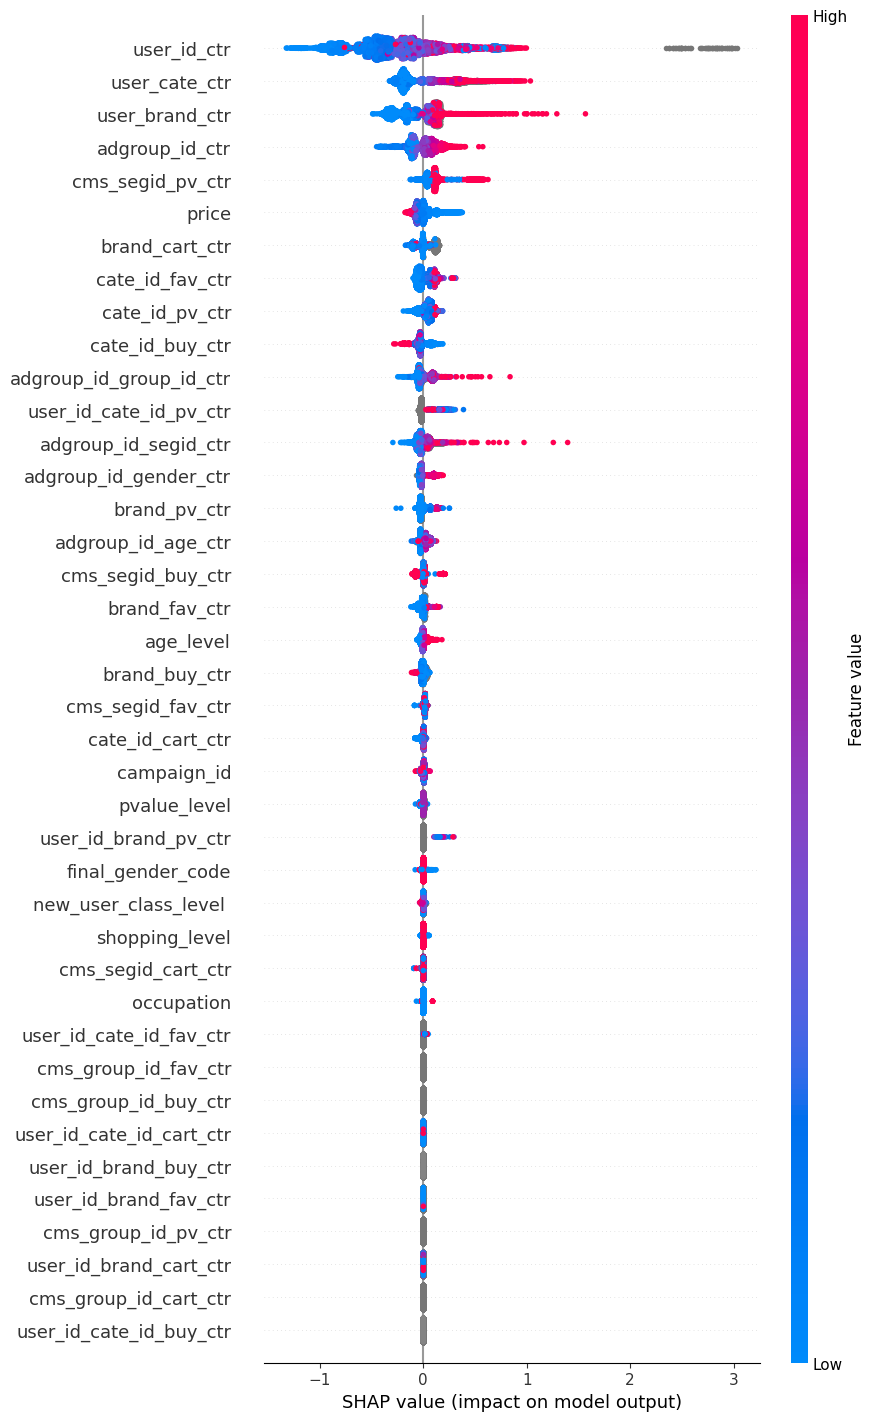

In [ ]:
import shap

explainer = shap.Explainer(ranking_model)
shap_values = explainer(test_dataset.sample(n=10000).drop(['target'] + drop_columns).to_pandas())

shap.plots.beeswarm(shap_values, max_display=50)

In [ ]:
behavioral_logs_sample = (
    behavioral_logs
    .to_dummies('btag')
    .rename({'user': 'user_id', 'cate': 'cate_id'})
    .join(user_features, left_on='user_id', right_on='userid')
)

behavioral_logs_cate_grouped_df = build_grouped_df(behavioral_logs_sample, ['cate_id'])
behavioral_logs_brand_grouped_df = build_grouped_df(behavioral_logs_sample, ['brand'])
behavioral_logs_user_segid_grouped_df = build_grouped_df(behavioral_logs_sample, ['cms_segid'])
behavioral_logs_user_groupid_by_period = build_grouped_df(behavioral_logs_sample, ['cms_group_id'])
behavioral_logs_user_cate_grouped_df = build_grouped_df(behavioral_logs_sample, ['user_id', 'cate_id'])
behavioral_logs_user_brand_grouped_df = build_grouped_df(behavioral_logs_sample, ['user_id', 'brand'])

In [ ]:
candidates_with_features = (
    pl.concat([
        pl.read_parquet('w2v_candidates.parquet').with_columns([pl.col('y_rec').apply(lambda x: x[:5])]),
        pl.read_parquet('als_candidates.parquet').with_columns([pl.col('y_rec').apply(lambda x: x[:10])])
    ])
    .explode('y_rec')
    .rename({'y_rec': 'adgroup_id'})
    .filter(pl.col('adgroup_id').is_not_null())
    .unique()
    .join(user_features, left_on='user_id', right_on='userid', how='left')
    .join(ad_features, 'adgroup_id', how='left')
    .join(behavioral_logs_user_cate_grouped_df, on=('user_id', 'cate_id'), how='left')
    .join(behavioral_logs_user_brand_grouped_df, on=('user_id', 'brand'), how='left')
    .join(behavioral_logs_cate_grouped_df, on='cate_id', how='left')
    .join(behavioral_logs_brand_grouped_df, on='brand', how='left')
    .join(behavioral_logs_user_segid_grouped_df, on='cms_segid', how='left')
    .join(behavioral_logs_user_groupid_by_period, on='cms_group_id', how='left')
)

candidates_with_features

user_id,adgroup_id,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cate_id,campaign_id,customer,brand,price,user_id_cate_id_buy_ctr,user_id_cate_id_fav_ctr,user_id_cate_id_pv_ctr,user_id_cate_id_cart_ctr,user_id_brand_buy_ctr,user_id_brand_fav_ctr,user_id_brand_pv_ctr,user_id_brand_cart_ctr,cate_id_buy_ctr,cate_id_fav_ctr,cate_id_pv_ctr,cate_id_cart_ctr,brand_buy_ctr,brand_fav_ctr,brand_pv_ctr,brand_cart_ctr,cms_segid_buy_ctr,cms_segid_fav_ctr,cms_segid_pv_ctr,cms_segid_cart_ctr,cms_group_id_buy_ctr,cms_group_id_fav_ctr,cms_group_id_pv_ctr,cms_group_id_cart_ctr
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
599304,660683,11,3,2,3,1,2,0,2,6251,81421,159580,209164,98.0,null,null,null,null,null,null,null,null,0.004194,0.005366,0.006742,0.006311,0.000601,0.000288,0.00025,0.000392,0.00044,0.000553,0.000692,0.00061,0.212932,0.233264,0.22911,0.221312
599304,274701,11,3,2,3,1,2,0,2,7339,218664,212320,null,1.1,null,null,null,null,null,null,null,null,0.002182,0.003516,0.002602,0.003113,null,null,null,null,0.00044,0.000553,0.000692,0.00061,0.212932,0.233264,0.22911,0.221312
599304,738468,11,3,2,3,1,2,0,2,4521,317105,114735,null,33.0,null,null,null,null,null,null,null,null,0.001756,0.006939,0.006087,0.004923,null,null,null,null,0.00044,0.000553,0.000692,0.00061,0.212932,0.233264,0.22911,0.221312
1048864,551517,43,5,2,5,2,3,0,1,11486,126551,174545,220064,12.0,null,null,null,null,null,null,null,null,0.000345,0.000423,0.000406,0.000419,0.000235,0.000318,0.000318,0.000321,0.0042,0.002724,0.003255,0.004327,0.128186,0.130575,0.12659,0.15459
795704,710164,0,10,1,4,null,3,0,3,1665,405490,60305,null,109.0,NaN,NaN,0.020833,NaN,null,null,null,null,0.002467,0.01415,0.01278,0.010289,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.085329,0.056129,0.072654,0.064769
558176,782118,0,3,2,3,null,3,0,2,1665,36784,125510,405202,168.0,0.0,0.0,0.043478,NaN,null,null,null,null,0.002467,0.01415,0.01278,0.010289,0.000013,0.000006,0.000011,0.000013,0.569418,0.566699,0.573221,0.568384,0.212932,0.233264,0.22911,0.221312
558176,713548,0,3,2,3,null,3,0,2,4520,296365,242104,403843,138.0,0.0,0.0,0.021739,NaN,null,null,null,null,0.020616,0.045788,0.040652,0.041238,0.000047,0.000137,0.000133,0.000138,0.569418,0.566699,0.573221,0.568384,0.212932,0.233264,0.22911,0.221312
894376,785674,0,4,2,4,null,3,0,2,6426,374638,117533,null,278.0,null,null,null,null,null,null,null,null,0.006236,0.025796,0.019907,0.018776,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.180932,0.16846,0.173065,0.200711
894376,578781,0,4,2,4,null,3,0,2,6426,177454,190701,27733,398.0,null,null,null,null,null,null,null,null,0.006236,0.025796,0.019907,0.018776,0.000015,0.000237,0.000138,0.000093,0.569418,0.566699,0.573221,0.568384,0.180932,0.16846,0.173065,0.200711


In [ ]:
for input_cols, new_col_name in rolling_ctr_features:
    candidates_with_features = candidates_with_features.join(
        data
        .rename({'user': 'user_id'})
        .join(user_features, left_on='user_id', right_on='userid', how='left')
        .join(ad_features, 'adgroup_id', how='left')
        .groupby(*input_cols)
        .agg(pl.col('clk').mean().alias(new_col_name)),
        on=input_cols,
        how='left'
    )

candidates_with_features

user_id,adgroup_id,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cate_id,campaign_id,customer,brand,price,user_id_cate_id_buy_ctr,user_id_cate_id_fav_ctr,user_id_cate_id_pv_ctr,user_id_cate_id_cart_ctr,user_id_brand_buy_ctr,user_id_brand_fav_ctr,user_id_brand_pv_ctr,user_id_brand_cart_ctr,cate_id_buy_ctr,cate_id_fav_ctr,cate_id_pv_ctr,cate_id_cart_ctr,brand_buy_ctr,brand_fav_ctr,brand_pv_ctr,brand_cart_ctr,cms_segid_buy_ctr,cms_segid_fav_ctr,cms_segid_pv_ctr,cms_segid_cart_ctr,cms_group_id_buy_ctr,cms_group_id_fav_ctr,cms_group_id_pv_ctr,cms_group_id_cart_ctr,user_cate_ctr,user_brand_ctr,adgroup_id_ctr,user_id_ctr,adgroup_id_group_id_ctr,adgroup_id_segid_ctr,adgroup_id_gender_ctr,adgroup_id_age_ctr
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
599304,660683,11,3,2,3,1,2,0,2,6251,81421,159580,209164,98.0,null,null,null,null,null,null,null,null,0.004194,0.005366,0.006742,0.006311,0.000601,0.000288,0.00025,0.000392,0.00044,0.000553,0.000692,0.00061,0.212932,0.233264,0.22911,0.221312,null,null,0.076831,0.074074,0.04908,0.0,0.077688,0.045685
599304,274701,11,3,2,3,1,2,0,2,7339,218664,212320,null,1.1,null,null,null,null,null,null,null,null,0.002182,0.003516,0.002602,0.003113,null,null,null,null,0.00044,0.000553,0.000692,0.00061,0.212932,0.233264,0.22911,0.221312,null,0.166667,0.095041,0.074074,0.12,null,0.093137,0.103261
599304,738468,11,3,2,3,1,2,0,2,4521,317105,114735,null,33.0,null,null,null,null,null,null,null,null,0.001756,0.006939,0.006087,0.004923,null,null,null,null,0.00044,0.000553,0.000692,0.00061,0.212932,0.233264,0.22911,0.221312,null,0.166667,0.102959,0.074074,0.111481,0.0,0.098846,0.117483
1048864,551517,43,5,2,5,2,3,0,1,11486,126551,174545,220064,12.0,null,null,null,null,null,null,null,null,0.000345,0.000423,0.000406,0.000419,0.000235,0.000318,0.000318,0.000321,0.0042,0.002724,0.003255,0.004327,0.128186,0.130575,0.12659,0.15459,null,null,0.06044,0.25,0.033333,null,0.067568,0.027778
795704,710164,0,10,1,4,null,3,0,3,1665,405490,60305,null,109.0,NaN,NaN,0.020833,NaN,null,null,null,null,0.002467,0.01415,0.01278,0.010289,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.085329,0.056129,0.072654,0.064769,null,0.166667,0.100361,0.2,0.076633,0.100662,0.092047,0.072352
558176,782118,0,3,2,3,null,3,0,2,1665,36784,125510,405202,168.0,0.0,0.0,0.043478,NaN,null,null,null,null,0.002467,0.01415,0.01278,0.010289,0.000013,0.000006,0.000011,0.000013,0.569418,0.566699,0.573221,0.568384,0.212932,0.233264,0.22911,0.221312,0.0,0.0,0.087627,0.011494,0.080964,0.086799,0.085157,0.082871
558176,713548,0,3,2,3,null,3,0,2,4520,296365,242104,403843,138.0,0.0,0.0,0.021739,NaN,null,null,null,null,0.020616,0.045788,0.040652,0.041238,0.000047,0.000137,0.000133,0.000138,0.569418,0.566699,0.573221,0.568384,0.212932,0.233264,0.22911,0.221312,0.0,0.0,0.074811,0.011494,0.070934,0.076204,0.077347,0.067204
894376,785674,0,4,2,4,null,3,0,2,6426,374638,117533,null,278.0,null,null,null,null,null,null,null,null,0.006236,0.025796,0.019907,0.018776,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.180932,0.16846,0.173065,0.200711,0.153846,0.0,0.053221,0.055556,0.072,0.052239,0.052262,0.067298
894376,578781,0,4,2,4,null,3,0,2,6426,177454,190701,27733,398.0,null,null,null,null,null,null,null,null,0.006236,0.025796,0.019907,0.018776,0.000015,0.000237,0.000138,0.000093,0.569418,0.566699,0.573221,0.568384,0.180932,0.16846,0.173065,0.200711,0.153846,0.0,0.079805,0.055556,0.068085,0.08172,0.078621,0.082759


In [ ]:
# некоторых колонок может не быть при выполнении операции drop
columns_to_drop = list(set(candidates_with_features.columns).intersection(drop_columns))
candidates_with_features = candidates_with_features.sort('user_id')

inference_pool = Pool(
    candidates_with_features.drop(columns_to_drop).to_pandas(),
    group_id=candidates_with_features['user_id'].to_list(),
    cat_features=cat_features
)

# для модели классификации нужно использовать метод predict_proba, который возвращает вероятности клика
ranked_candidates = candidates_with_features.with_columns([
    pl.Series(ranking_model.predict_proba(inference_pool)[:, 1]).alias('rank')
])

ranked_candidates

user_id,adgroup_id,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level,cate_id,campaign_id,customer,brand,price,user_id_cate_id_buy_ctr,user_id_cate_id_fav_ctr,user_id_cate_id_pv_ctr,user_id_cate_id_cart_ctr,user_id_brand_buy_ctr,user_id_brand_fav_ctr,user_id_brand_pv_ctr,user_id_brand_cart_ctr,cate_id_buy_ctr,cate_id_fav_ctr,cate_id_pv_ctr,cate_id_cart_ctr,brand_buy_ctr,brand_fav_ctr,brand_pv_ctr,brand_cart_ctr,cms_segid_buy_ctr,cms_segid_fav_ctr,cms_segid_pv_ctr,cms_segid_cart_ctr,cms_group_id_buy_ctr,cms_group_id_fav_ctr,cms_group_id_pv_ctr,cms_group_id_cart_ctr,user_cate_ctr,user_brand_ctr,adgroup_id_ctr,user_id_ctr,adgroup_id_group_id_ctr,adgroup_id_segid_ctr,adgroup_id_gender_ctr,adgroup_id_age_ctr,rank
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
4,458576,0,11,1,5,null,2,0,null,4282,208931,206024,null,85.0,null,null,null,null,null,null,null,null,0.007256,0.020175,0.018711,0.015937,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,null,0.137931,0.062268,0.060606,0.0199,0.063713,0.055862,0.037383,0.067523
4,671442,0,11,1,5,null,2,0,null,4281,94871,164284,null,98.0,NaN,NaN,0.571429,NaN,null,null,null,null,0.003085,0.014058,0.012854,0.009984,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,0.0,0.137931,0.049575,0.060606,0.043478,0.051927,0.062,0.047945,0.04552
4,687430,0,11,1,5,null,2,0,null,4284,254229,20262,null,99.0,null,null,null,null,null,null,null,null,0.003265,0.014431,0.013268,0.010026,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,null,0.137931,0.083333,0.060606,0.155556,0.084481,0.106771,0.083721,0.087226
4,728025,0,11,1,5,null,2,0,null,4281,408804,63559,234846,38.0,NaN,NaN,0.571429,NaN,null,null,null,null,0.003085,0.014058,0.012854,0.009984,0.001153,0.005481,0.005038,0.004065,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,0.0,null,0.088746,0.060606,0.105769,0.092152,0.082809,0.08284,0.083032
4,673760,0,11,1,5,null,2,0,null,4282,20657,10917,null,69.9,null,null,null,null,null,null,null,null,0.007256,0.020175,0.018711,0.015937,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,null,0.137931,0.081646,0.060606,0.142857,0.082429,0.095827,0.090909,0.080316
4,388902,0,11,1,5,null,2,0,null,562,159335,116625,null,29.0,null,null,null,null,null,null,null,null,0.002912,0.005545,0.004247,0.004279,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,0.1875,0.137931,0.069284,0.060606,0.066667,0.07393,0.039474,0.070588,0.068137
4,773194,0,11,1,5,null,2,0,null,4281,94871,164284,null,98.0,NaN,NaN,0.571429,NaN,null,null,null,null,0.003085,0.014058,0.012854,0.009984,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,0.0,0.137931,0.066504,0.060606,0.04,0.066851,0.062196,0.053812,0.052122
4,744872,0,11,1,5,null,2,0,null,4282,414149,45962,254132,141.0,null,null,null,null,null,null,null,null,0.007256,0.020175,0.018711,0.015937,0.000085,0.000376,0.000378,0.000252,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,null,null,0.076825,0.060606,0.041667,0.072527,0.069735,0.059041,0.062497
4,655187,0,11,1,5,null,2,0,null,4520,183194,118418,null,59.6,NaN,NaN,0.142857,NaN,null,null,null,null,0.020616,0.045788,0.040652,0.041238,null,null,null,null,0.569418,0.566699,0.573221,0.568384,0.069536,0.054627,0.061791,0.063481,0.0,0.137931,0.07125,0.060606,0.084615,0.072577,0.076375,0.044271,0.05505


In [ ]:
ranked_candidates_grouped = (
    ranked_candidates
    .groupby('user_id')
    .agg(['adgroup_id', 'rank'])
)

reranked_candidates = []
for user_id, item_ids, item_ranks in tqdm(ranked_candidates_grouped.rows()):
    reranked_candidates.append([
        int(user_id),
        # в качестве рекомендаций используем TOP_K объектов по убыванию скоро из ранжирующей модели
        [int(item_ids[ind]) for ind in np.argsort(item_ranks)[::-1][:TOP_K]]
    ])

reranked_candidates = pl.DataFrame(reranked_candidates, schema=['user_id', 'y_rec'])
reranked_candidates.write_parquet('reranked_candidates.parquet')
reranked_candidates

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284622/284622 [00:01<00:00, 180905.22it/s]


user_id,y_rec
i64,list[i64]
4,"[674497, 687430, … 628617]"
6,"[698147, 709851, … 736349]"
7,"[446024, 482801, … 657442]"
15,"[675674, 714441, … 627130]"
16,"[695844, 709851, … 648860]"
18,"[722036, 776726, … 520026]"
19,"[504643, 698147, … 758125]"
33,"[642488, 632432, … 478427]"
37,"[743102, 725105, … 595133]"


Увы, результаты тут не такие впечатляющие и добаление ранжирующей модели ухудшает офлайн-метрики. Это может быть по причине того, что собранный датасет содержит шумные данные (пользователь может не кликнуть на рекламное объявление просто потому что не увидел его).